# Determinación de la mejor ubicación para un nuevo pozo petrolero
La compañía Oily Giant está buscando un nuevo lugar para establecer un pozo petrolero.


**Tabla de contenidos**<a id='toc0_'></a>    
- [Objetivos](#toc1_)    
- [Exploración de los datos](#toc2_)    
- [Preparación de los datos](#toc3_)    
- [Entrenamiento y evaluación del modelo](#toc4_)    
- [Cálculo de ganancias](#toc5_)    
- [Cálculo de riesgos y ganancias para cada región](#toc6_)    
- [Conclusiones](#toc7_)    

<!-- vscode-jupyter-toc-config
	numbering=false
	anchor=true
	flat=false
	minLevel=2
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->


## <a id='toc1_'></a>[Objetivos](#toc0_)
- Entrenar un modelo de regresión lineal para predecir el volumen de petróleo que se puede extraer en un pozo en función de las características de este.
- Analizar los beneficios y riesgos potenciales utilizando la técnica bootstrapping para cada región.
- Seleccionar la región con el beneficio promedio más alto y un riesgo de pérdidas menor al 2.5%.

## <a id='toc2_'></a>[Exploración de los datos](#toc0_)
Se cuenta con tres datasets, uno por cada región. Cada dataset contiene 10.000 muestras de crudo. Para cada muestra se tiene información sobre la calidad del crudo y la cantidad de petróleo que se puede extraer en un pozo con esas características.

In [198]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import linear_model
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [199]:
try:
    df0 = pd.read_csv('./datasets/geo_data_0.csv')
    df1 = pd.read_csv('./datasets/geo_data_1.csv')
    df2 = pd.read_csv('./datasets/geo_data_2.csv')
except:
    df0 = pd.read_csv('/datasets/geo_data_0.csv')
    df1 = pd.read_csv('/datasets/geo_data_1.csv')
    df2 = pd.read_csv('/datasets/geo_data_2.csv')

In [200]:
# Información general de los dataframes
print(df0.info())
print(df1.info())
print(df2.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column  

Los datos muestran las siguientes columnas: 
- id — identificador único del pozo
- f0, f1, f2 — tres características del punto
- product — volumen de petróleo extraído del pozo (en miles de barriles)


No existen valores nulos en los datasets y los tipos de datos son correctos.

## <a id='toc3_'></a>[Preparación de los datos](#toc0_)
Se realizarán los siguiente pasos para preparar los datos: 
1. Seleccionar las columnas que se utilizarán para entrenar el modelo.
2. Dividir los datos en un conjunto de entrenamiento y otro de validación.
3. Escalar los datos utilizando el StandardScaler.

In [201]:
# Función para la preparación de los datos
def data_prep(df):
    
    df.drop('id', axis=1, inplace=True)
   
    features = df.drop('product', axis=1)
    target = df['product']
    
    features_train, features_valid, target_train, target_valid = train_test_split(
        features, target, test_size=0.25, random_state=12345)
    
    scaler = StandardScaler()
    numeric = ['f0', 'f1', 'f2']
    scaler.fit(features_train[numeric])
    features_train[numeric] = scaler.transform(features_train[numeric])
    features_valid[numeric] = scaler.transform(features_valid[numeric])
    return features_train, features_valid, target_train, target_valid

In [202]:
# Llamada a la función data_prep para cada dataframe
features_train0, features_valid0, target_train0, target_valid0 = data_prep(df0)
features_train1, features_valid1, target_train1, target_valid1 = data_prep(df1)
features_train2, features_valid2, target_train2, target_valid2 = data_prep(df2)


In [203]:
# Se comprueba el tamaño de los conjuntos resultantes para uno de los dataframes
print("Tamaño de los conjuntos generados a partir de df0:")
print("")
print(f"Conjunto de entrenamiento: {len(features_train0)}, {len(features_train0)/len(df0):.1%}")
print(f"Conjunto de validación: {len(features_valid0)}, {len(features_valid0)/len(df0):.1%}")
print(f"Conjunto original: {len(df0)}, {len(df0)/len(df0):.1%}")

Tamaño de los conjuntos generados a partir de df0:

Conjunto de entrenamiento: 75000, 75.0%
Conjunto de validación: 25000, 25.0%
Conjunto original: 100000, 100.0%


In [204]:
# Se revisan sus primeras filas
features_train0.head()

,f0,f1,f2
27212,-0.544828,1.390264,-0.094959
7866,1.455912,-0.480422,1.209567
62041,0.260460,0.825069,-0.204865
70185,-1.837105,0.010321,-0.147634
82230,-1.299243,0.987558,1.273181


## <a id='toc4_'></a>[Entrenamiento y evaluación del modelo](#toc0_)
Se entrenará un modelo de regresión lineal utilizando el conjunto de entrenamiento y se evaluará con el conjunto de validación utilizando como métricas el RMSE y el volumen promedio de las reservas previstas.

In [205]:
# Función para entrenar modelo de regresión lineal y predecir volúmenes
def train_predict(features_train, features_valid, target_train, target_valid):
    
    model = linear_model.LinearRegression()
    model.fit(features_train, target_train)
   
    predictions = model.predict(features_valid)
    
    mean_vol = predictions.mean()
    
    rmse = mean_squared_error(target_valid, predictions)**0.5
   
    print('Mean volume =', mean_vol)
    print('RMSE =', rmse)
    return predictions, mean_vol, rmse

In [206]:
# Llamada a la función train_predict para el dataframe de cada región
print('Region 0')
predictions0, mean_vol0, mse0 = train_predict(
    features_train0, features_valid0, target_train0, target_valid0)
print('Region 1')
predictions1, mean_vol1, mse1 = train_predict(
    features_train1, features_valid1, target_train1, target_valid1)
print('Region 2')
predictions2, mean_vol2, mse2 = train_predict(
    features_train2, features_valid2, target_train2, target_valid2)

Region 0
Mean volume = 92.59256778438035
RMSE = 37.5794217150813
Region 1
Mean volume = 68.728546895446
RMSE = 0.8930992867756168
Region 2
Mean volume = 94.96504596800489
RMSE = 40.02970873393434


Los resultados indican que la región 2 tiene el mayor volumen promedio de reservas previstas, seguido, con poca diferencia, de la región 0. Sin embargo, ambas regiones tienen un RMSE alto, lo que indica una alta discrepancia entre los valores reales y los predichos. La región 1, por su lado, tiene el volumen promedio de reservas previstas más bajo, pero una mayor precisión en las predicciones, dado su bajo RMSE.

## <a id='toc5_'></a>[Cálculo de ganancias](#toc0_)

Para cada región, se seleccionan los 200 mejores puntos para el cálculo de las ganancias. El presupuesto para el desarrollo de 200 pozos es de 100 millones de dólares.
Un barril de materias primas genera 4.5 USD de ingresos. El ingreso de una unidad de producto es de 4500 dólares (el volumen de reservas está expresado en miles de barriles).

In [207]:
wells_number = 200
budget = 100_000_000
budget_per_well = budget / wells_number
reserve_revenue = 4500
profitable_volume = budget_per_well / reserve_revenue
print(f"Profitable volume for a well: {profitable_volume:.2f}")

Profitable volume for a well: 111.11


El volumen mínimo de reservas aceptable para el desarrollo de un pozo es de 111.11 miles de barriles. Este volumen es mayor que el volumen promedio de reservas previstas para las tres regiones. Por lo tanto, el próximo paso es seleccionar los pozos con los volúmenes de reservas previstas más altos.

In [208]:
'''
Función para seleccionar los 200 pozos con las predicciones de volumen más altas
y calcular sus ganancias
'''
def profit(predictions, target):
    predictions = pd.Series(predictions)
    
    predictions_sorted = predictions.sort_values(ascending=False)
   
    selected = target.reset_index(drop=True)[predictions_sorted.index][:200]
    
    profit = selected.sum() * reserve_revenue - budget
    return profit

In [209]:
# Llamada a la función profit para cada región
profit0 = profit(predictions0, target_valid0)
profit1 = profit(predictions1, target_valid1)
profit2 = profit(predictions2, target_valid2)

print('Total profit of the selected top 200 wells')
print(f"Region 0: USD ${profit0:,.2f}")
print(f"Region 1: USD ${profit1:,.2f}")
print(f"Region 2: USD ${profit2:,.2f}")

Total profit of the selected top 200 wells
Region 0: USD $33,208,260.43
Region 1: USD $24,150,866.97
Region 2: USD $27,103,499.64


La Región 0 tiene el potencial de beneficio más alto considerando el volumen de reservas previstas y el presupuesto disponible. Por lo tanto, esta región podría ser la mejor opción para establecer el nuevo pozo petrolero.

## <a id='toc6_'></a>[Cálculo de riesgos y ganancias para cada región](#toc0_)

Se utilizará la técnica bootstrapping para determinar los riesgos y ganancias potenciales para cada región. Se generarán 1000 muestras de los datos y se calcularán los ingresos de cada muestra.
Encontraremos el promedio de los ingresos de las muestras de cada región y calcularemos su intervalo de confianza del 95%. Finalmente, determinaremos la probabilidad de obtener un ingreso negativo (riesgo).

In [210]:
# función para calcular el ingreso promedio, el intervalo de confianza y el riesgo de pérdida

def cal_profit_ci_risk(predictions, target):
    state = np.random.RandomState(12345)
    target = target.reset_index(drop=True)
    values = []
    for i in range(1000):
        target_subsample = target.sample(n=500, replace=True, random_state=state)
        probs_subsample = predictions[target_subsample.index]
        values.append(profit(probs_subsample, target_subsample))
    values = pd.Series(values)
    lower = values.quantile(0.025)
    upper = values.quantile(0.975)
    mean_profit = values.mean()
    risk = (values < 0).mean()
    print(f"Mean profit: USD ${mean_profit:,.2f}")  #print(f"Region 0: USD ${profit0:,.2f}")
    print(f"95% confidence interval: {lower:.2f}, {upper:.2f}")
    print(f"Risk of losses: {risk:.1%}")
    return values, mean_profit, lower, upper, risk

In [211]:
# llamada a la función cal_profit_ci_risk para cada región
print('Region 0')
values0, mean0, lower0, upper0, risk0 = cal_profit_ci_risk(predictions0, target_valid0)
print()
print('Region 1')
values1, mean1, lower1, upper1, risk1 = cal_profit_ci_risk(predictions1, target_valid1)
print()
print('Region 2')
values2, mean2, lower2, upper2, risk2 = cal_profit_ci_risk(predictions2, target_valid2)

Region 0
Mean profit: USD $3,961,649.85
95% confidence interval: -1112155.46, 9097669.42
Risk of losses: 6.9%

Region 1
Mean profit: USD $4,560,451.06
95% confidence interval: 338205.09, 8522894.54
Risk of losses: 1.5%

Region 2
Mean profit: USD $4,044,038.67
95% confidence interval: -1633504.13, 9503595.75
Risk of losses: 7.6%


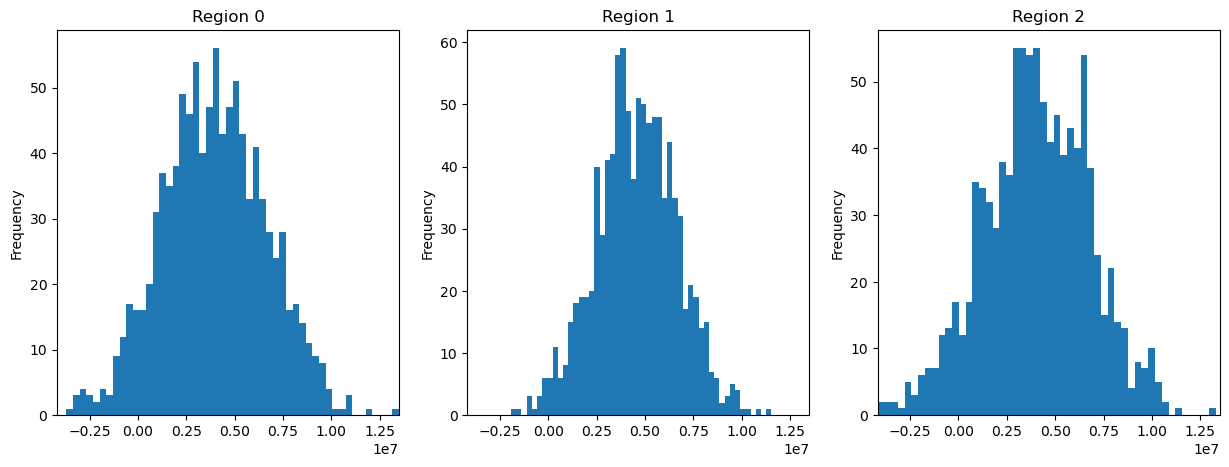

In [212]:
# Histograma de las ganancias para cada región
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
values0.plot(kind='hist', bins=50, ax=axes[0], title='Region 0')
values1.plot(kind='hist', bins=50, ax=axes[1], title='Region 1')
values2.plot(kind='hist', bins=50, ax=axes[2], title='Region 2')
x_min = min(values0.min(), values1.min(), values2.min())
x_max = max(values0.max(), values1.max(), values2.max())
for ax in axes:
    ax.set_xlim(x_min, x_max)
plt.show()

De los histogramas se observa que la distribución de los ingresos para cada región se aproxima a una distribución normal y que, en general, los ingresos son positivos a pesar de que existen algunos valores negativos que representan pérdidas.


## <a id='toc7_'></a>[Conclusiones](#toc0_)


En promedio, la Región 1 tiene las mayores ganancias, con un valor de aproximadamente USD $4,560,451.06. Adicionalmente, su intervalo de confianza del 95% es el más estrecho, lo que indica una mayor precisión en la estimación del promedio de ganancias para esta región. Su riesgo de pérdidas es del 1.5%, siendo el único caso en que es menor al 2.5% requerido. En vista de estos resultados, se concluye que la Región 1 es la mejor opción para establecer el nuevo pozo petrolero.